In [18]:
from typing_extensions import Annotated, List, Union, TypedDict, Optional, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain.document_loaders import PyPDFLoader
from langchain_groq import ChatGroq
import requests

In [19]:
memory = InMemorySaver()

In [20]:
# Define LangGraph state
class State(TypedDict, total=False):
    messages: Annotated[List[Union[HumanMessage, AIMessage]], add_messages]
    symptoms: list[str]
    patient_details: dict[str, str]
    weather_info: dict[str, str]
    human: str
    report: Optional[str]
    analysis: str
    generated_symptoms: str
    diagnosis_result: str
    final_plan: str

In [21]:
pdf_path = r"C:\Users\Pradeep\Downloads\Pradeep_Resume_.pdf"

In [22]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
Weather_Api_Key = os.getenv("WEATHER_API_KEY")
llm = ChatGroq(model="llama-3.1-8b-instant", verbose=True, temperature=0)


In [23]:
symptoms = []
patient_details = {"Name":"Pradeep", "Gender":"male", "Location":"Noida", "country": "India", "Weight":"58kg", "Height":"167cm"}
# query = input("Please enter your symptoms: ")

def user_input(query) -> None:
    """Get Patient input and append to symptoms."""
    symptoms.append(query.strip())

# user_input(query)

def user_report(pdf_path: str) -> str:
    pdf = PyPDFLoader(pdf_path)
    load = pdf.load()
    return load[0].page_content

# report = user_report(pdf_path) if pdf_path else None

In [ ]:
# Weather API helper
def get_weather(location: str) -> str:
    # Example: open-meteo, weatherapi.com, or your API
    url = f"http://api.weatherapi.com/v1/current.json?key={Weather_Api_Key}&q={location}&days=3"
    res = requests.get(url).json()
    weather_info = {
        "Condition": res["current"]["condition"]["text"],
        "Temperature": f"{res['current']['temp_c']} °C",
        "Humidity": f"{res['current']['humidity']}%",
        "Air Quality": res["current"].get("air_quality", {}),
        "Rainfall": f"{res['current'].get('precip_mm', 0)} mm",
        "Pressure": f"{res['current']['pressure_mb']} mb",
        "Wind": f"{res['current']['wind_kph']} kph {res['current']['wind_dir']}",
        "UV Index": res["current"].get("uv", "N/A"),
        "Region": res["location"]["region"],
        "Local Time": res["location"]["localtime"]
    }
    return weather_info


def symptoms_analysis(symptoms, patient_details, weather_info, report=None) -> str:
    prompt = f"""
    You are an experienced MBBS doctor. Analyze the patient’s symptoms, report (if available), and weather conditions step by step.  
    Identify the **most likely common diseases** that match, considering seasonal or environment-related factors.  

    ### Instructions
    1. Use patient details (age, gender, location, weather, lifestyle hints if present).  
    2. Integrate report findings if provided.  
    3. Focus on **common, likely diseases**.  
    4. Avoid rare diseases unless symptoms strongly suggest them.  
    5. Output **only a clean bullet list of possible diseases** (no explanations).  

    ### Few-shot Example
    Input Symptoms: ["frequent urination", "thirst", "weight loss"]  
    Output Diseases:  
    - Type 2 Diabetes Mellitus  
    - Urinary Tract Infection  
    - Hyperthyroidism  

    Input Symptoms: ["joint pain", "stiffness", "difficulty walking"]  
    Output Diseases:  
    - Osteoarthritis  
    - Rheumatoid Arthritis  
    - Vitamin D Deficiency 

    Patient Details:
    {patient_details}

    If weather clearly influences the symptoms (e.g., seasonal allergies, heat exhaustion, viral outbreaks), include it.
    Otherwise ignore it completely.
    Current Weather:
    {weather_info}

    Patient Symptoms:
    {symptoms}

    Patient Report Data (if available, use to confirm or reject possibilities):
    {report}
    
    First, analyze each symptom logically.
    Then, combine symptoms into clusters of possible conditions.
    Finally, output ONLY a bullet list of the most likely diseases.

    Your Answer:
    e.g
    - Common Cold = Viral Upper Respiratory Infection
    - Vitamin B12 Deficiency = Fatigue, Weakness
    - Viral Pharyngitis = Sore Throat, Cough
    - Diabetes = Increased Thirst, Frequent Urination
    ....
    """
    return llm.invoke(prompt)


def more_symptoms(symptoms, patient_details, weather_info, analysis, report=None) -> str:
    prompt = f"""
    You are a MBBS doctor. Suggest additional symptoms that are **medically realistic and commonly associated** with the patient’s suspected condition.  

    ### Instructions
    1. Suggest **3–5 additional symptoms** only.  
    2. Use short **keywords only** (e.g., "fatigue, headache, nausea").  
    3. Avoid long sentences.  
    4. Exclude rare or unrelated symptoms.  
    5. Output must be a **comma-separated list only**.  

    ### Few-shot Example
    Input Symptoms: ["fever"]  
    Output: cough, body ache, headache  

    ---

    Patient Details:
    {patient_details}

    Current Weather (ignore if irrelevant to symptoms):
    {weather_info}

    Patient Symptoms:
    {symptoms}

    Patient Disease Analysis (for reference, not final):
    {analysis}

    Patient Report Data:
    optional[{report}]
    
    Your Answer:
    e.g. 
    Based on previous symptoms and disease below symptoms can be more?
    - fatigue
    - headache
    - nausea 
    - ....
    """
    return llm.invoke(prompt)

def diagnosis(symptoms, patient_details, analysis, report=None) -> str:
    prompt = f"""
You are a highly experienced MBBS & MD physician. Provide a structured **diagnostic reasoning note** based on the patient’s symptoms, report, and preliminary analysis.  

### Instructions
1. Analyze each symptom individually and link to possible conditions.  
2. Cross-check with **patient details** (age, gender, weight, height, location, weather).  
3. Integrate report findings (if available).  
4. Consider at least **2–3 differential diagnoses**.  
5. Eliminate mismatches logically.  
6. Provide one **Primary Diagnosis** and at least two differentials.  

### Few-shot Example
Input Symptoms: ["fever", "cough", "sore throat"]  
Output:  
Primary Diagnosis: Viral Pharyngitis  
Possible Differential Diagnoses:  
- Influenza  
- Bacterial Tonsillitis 

Input Symptoms: ["frequent urination", "thirst", "weight loss"]  
Output:  
Primary Diagnosis: Type 2 Diabetes Mellitus  
Possible Differential Diagnoses:  
- Urinary Tract Infection  
- Hyperthyroidism

Patient Details:
{patient_details}

Symptoms:
{symptoms}

Previous Analysis (for reference, not final):
{analysis}

Patient Report Data (if available, use to confirm or reject possibilities):
{report}

Before giving the final diagnosis, you must think in depth step by step.
<think>
your thinking area
</think>

Provide **one Primary Diagnosis (the most likely)**.  
If two are equally strong, list both together.  

Your Answer:
Primary Diagnosis: <one or two conditions most strongly supported>
Possible Differential Diagnoses:
- Differential 1
- Differential 2
- Differential 3 
"""
    return llm.invoke(prompt)


def treatment_plan(diagnosis_result: str) -> str:
    prompt = f"""
You are a Senior MBBS & MD doctor. Based on the **final diagnosis result**, prepare a safe and evidence-based **treatment plan**.  
Be precise, clinically realistic, and patient-friendly. 

Diagnosis Result (to analyze):
{diagnosis_result}


Before giving your plan, think step by step in depth.

<think>
- Recheck the diagnosis against common symptoms
- Consider possible complications
- Identify immediate vs. long-term precautions
- Suggest safe, widely used treatments
- Recommend supportive care (diet, lifestyle)
- Add follow-up tests if uncertainty remains
</think>

For each possible primary diagnosis, suggest a safe treatment plan.
If multiple conditions are possible, outline supportive care that is safe in all.

Final Output:
Diagnosis Result:
e.g.
- Type 2 Diabetes Mellitus
- Vitamin B12 Deficiency
- Viral Fever
- Constipation

Treatment Plan: (use structured sections)
e.g.
Disease 1: Type 2 Diabetes Mellitus (Reason: Insulin resistance leading to hyperglycemia)
Precautions:
- Monitor blood sugar levels regularly
- Follow a diabetic diet (low sugar, low carb)
- Exercise regularly (30 minutes of moderate activity most days e.g. Yoga, Walking, Running)
- Maintain a healthy weight
Medicines:
- Commonly prescribed: Metformin (dose as advised by doctor)
- Home monitoring with Glucometer
- Insulin (if prescribed)
Diet Plan:
- Low sugar, high fiber foods (whole grains, legumes)
- Non-starchy vegetables (leafy greens, broccoli)
- Healthy fats (avocado, nuts)
- Lean protein (chicken, fish, tofu)
Suggested Tests:
- Fasting blood glucose
- HbA1c

Disease 2:
Precautions:
Medicines:
Diet Plan:
Suggested Tests:

Disease 3: Viral Fever (Reason: Likely viral infection)
Precautions:
Medicines:
Diet Plan:
Suggested Tests (if symptoms persist >5 days):
  
....

Common Supportive Measures:
- Adequate hydration
- Healthy diet rich in vegetables, fruits, and whole grains
"""
    return llm.invoke(prompt)

In [25]:
# weather_info = get_weather(patient_details["Location"])

# analysis = symptoms_analysis(symptoms, patient_details, weather_info, report=None)
# generated_symptoms = more_symptoms(symptoms, patient_details, weather_info, analysis, report=None)
# diagnosis_result = diagnosis(symptoms, patient_details, analysis, report=None)
# plan = treatment_plan(diagnosis_result)

In [26]:

def node_symptoms_analysis(state: State):
    result = symptoms_analysis(
        state["symptoms"],
        state["patient_details"],
        state["weather_info"],
        state.get("report")
    )
    text = result.content if hasattr(result, "content") else str(result)
    return {"analysis": text, "messages": [AIMessage(content=text)]}


def node_generated_symptoms(state: State):
    result = more_symptoms(
        state["symptoms"],
        state["patient_details"],
        state["weather_info"],
        state.get("analysis"),
        state.get("report")
    )
    text = result.content if hasattr(result, "content") else str(result)
    return {"generated_symptoms": text, "messages": [AIMessage(content=text)]}


def node_diagnosis(state: State):
    result = diagnosis(
        state["symptoms"],
        state["patient_details"],
        state.get("analysis"),
        state.get("report")
    )
    text = result.content if hasattr(result, "content") else str(result)
    return {"diagnosis_result": text, "messages": [AIMessage(content=text)]}


def node_treatment_plan(state: State):
    result = treatment_plan(state["diagnosis_result"])
    text = result.content if hasattr(result, "content") else str(result)
    return {"final_plan": text, "messages": [AIMessage(content=text)]}

In [27]:
def human_assistance(state: State):
    """Ask the patient to confirm whether the generated symptoms match their experience."""
    options = ("Symptoms_Matched", "Symptoms_Not_Matched")
    response = interrupt(options)
    return {"human": response}

In [28]:
def human_decision(state: State) -> str:
    """Decide next step based on human input."""
    human_value = state.get("human", "")
    if human_value == "Symptoms_Matched":
        return "Symptoms_Matched"
    else:
        return "Symptoms_Not_Matched"

In [29]:
def add_symptoms(state: State):
    more = input("Please enter additional symptoms, separated by commas: ")
    new_syms = [sym.strip() for sym in more.split(",") if sym.strip()]
    return {"symptoms": state["symptoms"] + new_syms}

In [30]:
builder = StateGraph(State)
builder.add_node("Symptoms_Analysis", node_symptoms_analysis)
builder.add_node("Generated_Symptoms", node_generated_symptoms)
builder.add_node("Patient_Confirmation", human_assistance)
builder.add_node("Need_More_Symptoms", add_symptoms)
builder.add_node("Diagnosis", node_diagnosis)
builder.add_node("Final_Report", node_treatment_plan)

builder.add_edge(START, "Symptoms_Analysis")
builder.add_edge("Symptoms_Analysis", "Generated_Symptoms")
builder.add_edge("Generated_Symptoms", "Patient_Confirmation")
builder.add_conditional_edges(
    "Patient_Confirmation",
    human_decision,
    {"Symptoms_Matched": "Diagnosis", "Symptoms_Not_Matched": "Need_More_Symptoms"}
)
builder.add_edge("Need_More_Symptoms", "Symptoms_Analysis")
builder.add_edge("Diagnosis", "Final_Report")
builder.add_edge("Final_Report", END)

builder.set_entry_point("Symptoms_Analysis")
builder.set_finish_point("Final_Report")

graph = builder.compile(checkpointer=memory)


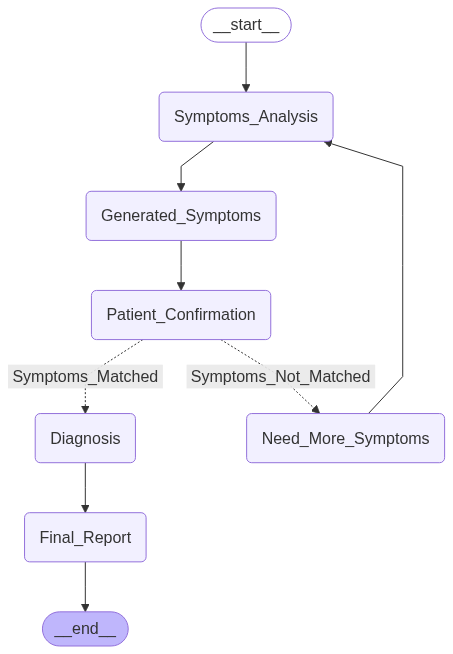

In [31]:
from IPython.display import Image, display
try:  
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [43]:
weather_info = get_weather(patient_details["Location"])
config = {"configurable": {"thread_id": "1"}}
initial_state = {
    "symptoms": ["tiredness", "headache", "dizziness"],
    "patient_details": patient_details,
    "weather_info": weather_info,
    "report": None,
}

In [44]:
events = graph.invoke(input=initial_state, config=config)
events

{'messages': [AIMessage(content="Based on the patient's symptoms, location, and weather conditions, here's the analysis:\n\n1. **Tiredness**: This symptom can be associated with various conditions, including anemia, vitamin B12 deficiency, hypothyroidism, and chronic fatigue syndrome.\n2. **Headache**: This symptom can be associated with migraines, tension headaches, sinusitis, and viral infections.\n3. **Dizziness**: This symptom can be associated with inner ear problems, dehydration, low blood pressure, and viral infections.\n\nConsidering the patient's symptoms together, here are the possible disease clusters:\n\n- **Viral Infection**: The combination of headache, dizziness, and tiredness could suggest a viral infection, such as a common cold or flu.\n- **Dehydration**: The symptoms of headache, dizziness, and tiredness can also be associated with dehydration, especially in hot and humid weather conditions.\n- **Hypothyroidism**: The symptoms of tiredness, headache, and dizziness ca

In [34]:
print(events["messages"][-1].content)

Based on the patient's symptoms and disease analysis, additional symptoms can be:

fatigue, nausea, muscle weakness, joint pain, loss of appetite


In [ ]:
resume = graph.invoke(Command(resume="Symptoms_Matched"), config)
resume

{'messages': [AIMessage(content="Based on the patient's symptoms, location, and weather conditions, here's the analysis:\n\n1. **Tiredness**: This symptom can be associated with various conditions, including anemia, vitamin B12 deficiency, hypothyroidism, and chronic fatigue syndrome.\n2. **Headache**: This symptom can be associated with migraines, tension headaches, sinusitis, and viral infections.\n3. **Dizziness**: This symptom can be associated with inner ear problems, dehydration, low blood pressure, and viral infections.\n\nConsidering the patient's symptoms together, here are the possible disease clusters:\n\n- **Viral Infection**: The combination of headache, dizziness, and tiredness could suggest a viral infection, such as a common cold or flu.\n- **Dehydration**: The symptoms of headache, dizziness, and tiredness can also be associated with dehydration, especially in hot and humid weather conditions.\n- **Hypothyroidism**: The symptoms of tiredness, headache, and dizziness ca

In [37]:
print(resume["messages"][-1].content)

**Diagnosis Result:**
- **Viral Upper Respiratory Infection** (Reason: Combination of headache, dizziness, and tiredness, likely due to viral infection)
- **Dehydration** (Reason: Symptoms of headache, dizziness, and tiredness, especially in hot and humid weather conditions)
- **Hypothyroidism** (Reason: Symptoms of tiredness, headache, and dizziness, which can be associated with hypothyroidism)

**Treatment Plan:**

**Disease 1: Viral Upper Respiratory Infection**

Precautions:
- Rest and avoid strenuous activities
- Stay hydrated by drinking plenty of fluids (water, clear broths, electrolyte-rich beverages)
- Use a humidifier to relieve congestion
- Avoid close contact with others to prevent transmission

Medicines:
- Commonly prescribed: Acetaminophen (dose as advised by doctor) for pain and fever relief
- Antihistamines (dose as advised by doctor) for allergic symptoms
- Decongestants (dose as advised by doctor) for nasal congestion

Diet Plan:
- Warm liquids (broth, soup) to sooth

In [17]:
resume = graph.invoke(Command(resume="Symptoms_Not_Matched"), config)
resume

{'messages': [AIMessage(content="Based on the patient's symptoms, location, and weather conditions, here's the analysis:\n\n1. **Tiredness**: This symptom can be associated with various conditions, including anemia, vitamin B12 deficiency, hypothyroidism, and chronic fatigue syndrome.\n2. **Headache**: This symptom can be associated with migraines, tension headaches, sinusitis, and viral infections.\n3. **Dizziness**: This symptom can be associated with inner ear problems, dehydration, low blood pressure, and viral infections.\n\nConsidering the patient's symptoms together, here are the possible disease clusters:\n\n- **Viral Infection**: The combination of headache, dizziness, and tiredness could suggest a viral infection, such as a common cold or flu.\n- **Dehydration**: The symptoms of headache, dizziness, and tiredness can also be associated with dehydration, especially in hot and humid weather conditions.\n- **Hypothyroidism**: The symptoms of tiredness, headache, and dizziness ca

In [ ]:
events = graph.stream(input=(initial_state, Command(resume=True)), config=config)
for event in events:
    if "messages" in event and event["messages"]:
        event["messages"][-1].pretty_print()
    else:
        print(event)


In [ ]:
events = graph.stream(input=(initial_state, Command(resume=True)), config=config)

while True:
    interrupted = False
    for event in events:
        if "__interrupt__" in event:
            interrupted = True
            interrupt_val = event["__interrupt__"]
            print(f"⚠️ Interrupt: {interrupt_val}")

            user_choice = input("Your response (1 = Matched, 2 = Not Matched): ")

            # resume only with Command, not initial_state
            events = graph.stream(
                input=Command(resume=user_choice),
                config=config
            )
            break  # restart outer while loop
        elif "messages" in event and event["messages"]:
            event["messages"][-1].pretty_print()
        else:
            print(event)

    if not interrupted:  
        # no more interrupts → must have finished (Final_Report reached)
        break

In [ ]:
events = graph.stream(input=(initial_state, Command(resume=True)), config=config)

while True:
    interrupted = False
    for event in events:
        if "__interrupt__" in event:
            interrupted = True
            interrupt_val = event["__interrupt__"]

            user_choice = input("Your response (1 = Matched, 2 = Not Matched): ")

            events = graph.stream(
                input=Command(resume=user_choice),
                config=config
            )
            break  # restart outer while loop

        elif "Generated_Symptoms" in event:
            gen = event["Generated_Symptoms"]["generated_symptoms"]
            print(f"\n📝 Suggested Symptoms: {gen}\n")

        elif "Final_Report" in event:
            final = event["Final_Report"]["final_plan"]
            print(f"\n✅ Final Report:\n{final}\n")

        else:
            continue  

    if not interrupted:
        # finished (Final_Report reached)
        break


In [ ]:
human_response = "2"  # or "2"
config = {"configurable": {"thread_id": "1"}}

# Resume
events = graph.stream(Command(resume=human_response), config)
for event in events:
    if "messages" in event and event["messages"]:
        event["messages"][-1].pretty_print()
    else:
        print(event)

In [ ]:
human_response = "1"  # or "2"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(Command(resume=human_response), config)
for event in events:
    if "messages" in event and event["messages"]:
        event["messages"][-1].pretty_print()
    else:
        print(event)